In [126]:
# inversion calculation

In [127]:
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [128]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re
import cartopy.crs as ccrs
import pandas as pd
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable from my custom Python script

In [129]:
name_month = 'Mar' # Jan, Feb, Mar
imonth = 3 # 1,2,3

In [130]:
input_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/python/data/'
output_directory = input_directory
delta_y0_file = 'delta_y0_model_' + name_month + '.nc'
xco2_file = 'XCO2_mod_and_oco2_' + name_month + '.nc'

# Name of output netCDF file
output_file = 'posterior.nc'

In [131]:
ds_delta_y0 = xr.open_dataset(input_directory + delta_y0_file)
varnames = list(ds_xco2_model.data_vars.keys())

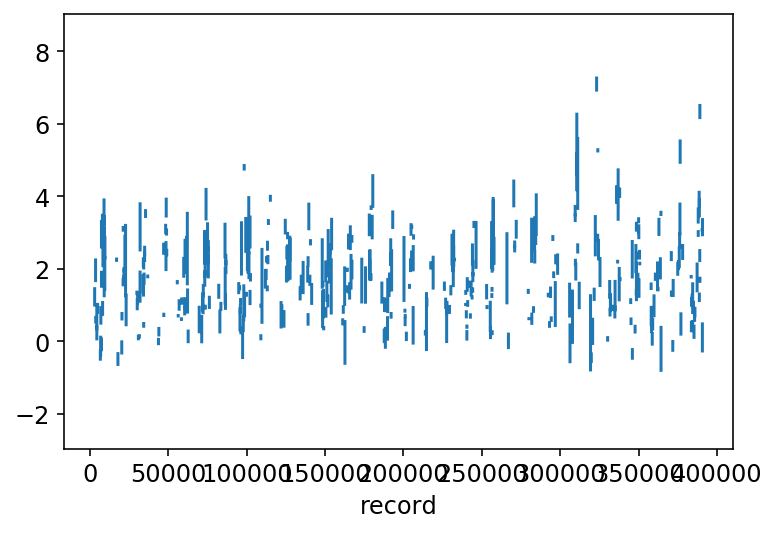

In [132]:
ds_xco2 = xr.open_dataset(input_directory + xco2_file)
diff = ds_xco2['xco2_oco2'] - ds_xco2['xco2_model']
diff.plot()

In [133]:
# reduce the size of array and matrix, from 400k to 10k
xco2_oco2 = ds_xco2['xco2_oco2']
x = xco2_oco2.copy()
x = x[np.logical_not(np.isnan(x))]
ind = x.record.values # index for slicing
length = len(ind)
length

4681

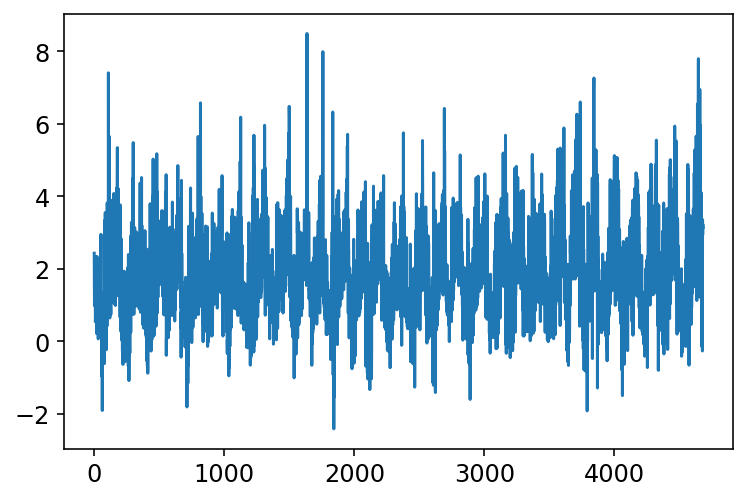

In [134]:
diff_slice = diff[ind].values
np.shape(diff_slice)
plt.plot(diff_slice) # same as above, excluded nan values

In [135]:
del_Y_matrix = np.empty((length,22))
del_Y_matrix[:] = np.nan
print(np.shape(del_Y_matrix))

for itag in range(22):
    name_var = 'X_SpeciesConc_CO2Tag' + str(itag+1)
    del_Y_matrix[:,itag] = ds_delta_y0[name_var][ind].values

(4681, 22)


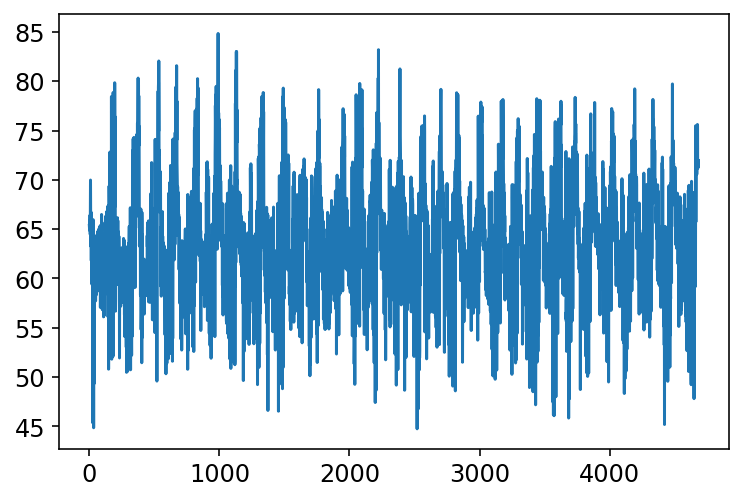

In [136]:
plt.plot(del_Y_matrix[:,10])

In [137]:
del_Y_tran = np.matrix.transpose(del_Y_matrix)
first = np.matmul(del_Y_matrix,del_Y_tran)
print(np.shape(first))

random_error = np.random.random_sample(length)
#random_error = np.random.randn(length)
obs_error = np.empty((length,length))
print(np.shape(obs_error))
for idiag in range(length):
    obs_error[idiag, idiag] = random_error[idiag]
obs_error

(4681, 4681)
(4681, 4681)


array([[0.42992571, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.80524441, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.5307636 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.852566  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.83197985,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.31883763]])

In [138]:
second = np.linalg.inv(first+obs_error)
second

array([[ 2.32582992e+00, -7.98155228e-05, -1.18841575e-04, ...,
         2.15232315e-05, -1.93145891e-05, -1.13783165e-04],
       [-7.98155491e-05,  1.24181718e+00, -6.24743834e-05, ...,
         1.08142114e-05, -1.07246176e-05, -6.11185106e-05],
       [-1.18841589e-04, -6.24743775e-05,  1.88398431e+00, ...,
         1.55278464e-05, -1.66023869e-05, -9.25088389e-05],
       ...,
       [ 2.15232544e-05,  1.08142266e-05,  1.55278471e-05, ...,
         1.16915857e+00, -1.75235310e-03, -1.15158134e-03],
       [-1.93146263e-05, -1.07246476e-05, -1.66024148e-05, ...,
        -1.75235312e-03,  1.20103135e+00, -8.84109987e-04],
       [-1.13783082e-04, -6.11185533e-05, -9.25088858e-05, ...,
        -1.15158136e-03, -8.84109915e-04,  3.13483851e+00]])

In [139]:
third = np.matmul(del_Y_tran,second)
#plt.plot(third)
np.shape(third)

(22, 4681)

In [140]:
random_error = np.random.random_sample(22)
random_error

array([0.31063885, 0.12153749, 0.55607158, 0.1244795 , 0.93436675,
       0.28189174, 0.0497943 , 0.47906352, 0.11332224, 0.16950774,
       0.14060583, 0.73517408, 0.16820455, 0.43943299, 0.13251144,
       0.29568332, 0.81897059, 0.12358252, 0.73314188, 0.29456133,
       0.89267443, 0.57257638])

In [141]:
#random_error = np.random.random_sample(22)
del_X_f = np.zeros((22,22))
for idiag in range(22):
    del_X_f[idiag,idiag] = 1.0/21 # GrC/yr
#del_X_f

In [142]:
k_e = np.matmul(del_X_f,third)
np.shape(k_e)

(22, 4681)

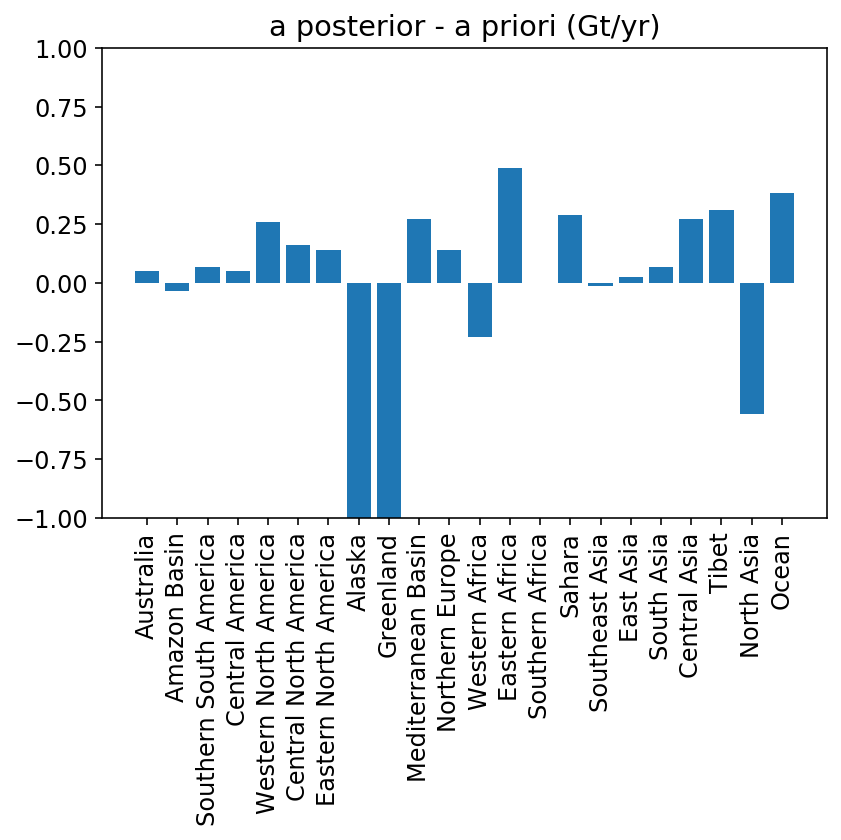

In [143]:
adjust = np.matmul(k_e, diff_slice)

fig = plt.figure(figsize=[6, 6])
plt.bar(region_names, adjust)
plt.ylim(top   = 1,bottom = -1)
plt.title('a posterior - a priori (Gt/yr)')
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig(output_directory+'adjustment_' + name_month +'.png', dpi=300)

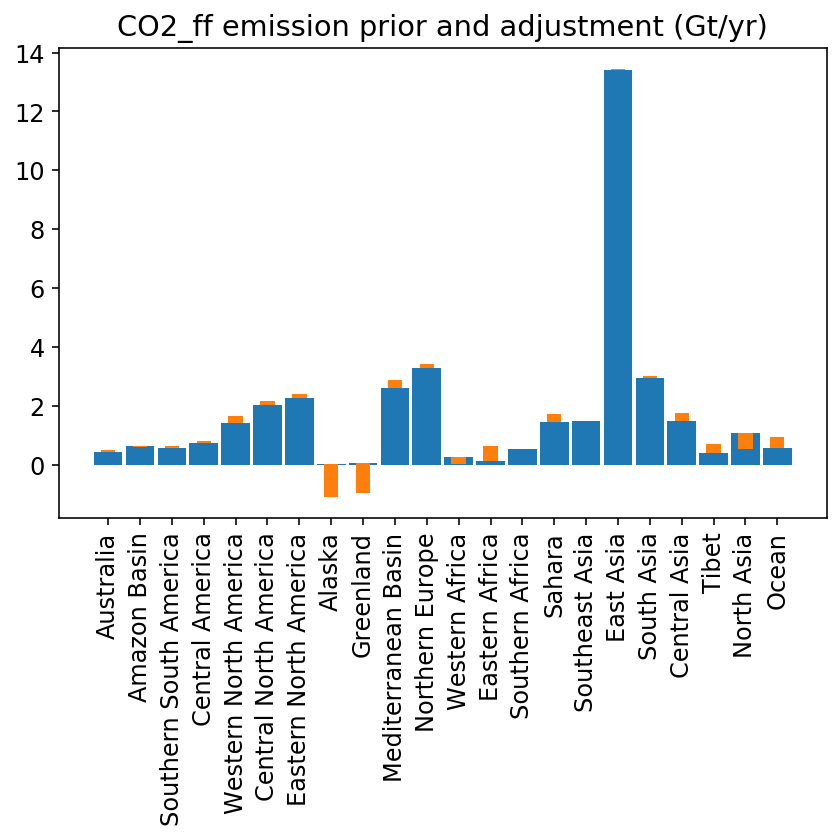

In [144]:
df = pd.read_csv(input_directory + 'base_emission.csv')
region_names = df['name'].values
prior_emission = df['emission'].values

fig = plt.figure(figsize=[6, 6])
width = 0.9
plt.bar(region_names, prior_emission, width)
plt.bar(region_names, adjust, width*0.5, bottom = prior_emission)
plt.title('CO2_ff emission prior and adjustment (Gt/yr)')
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig(output_directory+'posterior_' + name_month +'.png', dpi=300)